# Notebook to implement and test the halo field of UF23 Model

In [72]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### General Constants

In [5]:
kPi = np.pi
kTwoPi = 2 * kPi
degree = kPi / 180.
kpc = 1
microgauss = 1
megayear = 1
Gpc = 1e6 * kpc
pc = 1e-3 * kpc
second = megayear / (1e6 * 60 * 60 * 24 * 365.25)
kilometer = kpc / 3.0856775807e+16

### General Functions

In [127]:
def cyl_to_cart(v, cos_phi, sin_phi):
    """
    Converts cylindrical coordinates to cartesian coordinates.
    Arguments:
    v : array_like
        Cylindrical coordinates vector (r, theta, z)
    cos_phi : float
        Cosine of the angle phi
    sin_phi : float
        Sine of the angle phi
    
    Returns:
    numpy array representing the Cartesian coordinates (x, y, z)
    """
    return np.array([v[0] * cos_phi - v[1] * sin_phi,
                     v[0] * sin_phi + v[1] * cos_phi,
                     v[2]
                     ])

def cart_to_cyl(v, cos_phi, sin_phi):
    """
    Converts cartesian coordinates to cylindrical coordinates.
    Arguments:
    v : array_like
        Cartesian coordinates vector (x, y, z)
    cos_phi : float
        Cosine of the angle phi
    sin_phi : float
        Sine of the angle phi
    
    Returns:
    numpy array representing the Cylindrical coordinates (r, theta, z)
    """
    return np.array([v[0] * cos_phi + v[1] * sin_phi,
                     -v[0] * sin_phi + v[1] * cos_phi,
                     v[2]
                     ])

def sigmoid(x, x0, w):
    """
    Calculates the logistic sigmoid function.
    Arguments:
    x : float
        The input value
    x0 : float
        The midpoint of the sigmoid
    w : float
        The width of the sigmoid
    
    Returns:
    The result of the sigmoid function
    """
    return 1 / (1 + np.exp(-(x - x0) / w))

def delta_phi(phi0, phi1):
    """
    Calculates the angle between v0 = (cos(phi0), sin(phi0)) and v1 = (cos(phi1), sin(phi1)).
    Arguments:
    phi0 : float
        First angle in radians
    phi1 : float
        Second angle in radians
    
    Returns:
    The angle between v0 and v1 in radians.
    """
    return np.arccos(np.cos(phi1) * np.cos(phi0) + np.sin(phi1) * np.sin(phi0))

def sign(b, x, y):
    """
    Returns the sign of B-Field strength depending on quadrant.
    For plotting.
    Positive field vector is counterclockwise with respect to the origin
    in x-y plane.
    Negative field clockwise...
    Arguments:
    b : array_like
        b-field in cartesian coordinates
    x : float
        x-position of b-field vector
    y : float
        y-position of b-field vector
    """
    if x>=0 and y>=0:
        return 1 if b[1]>0 else -1
    elif x<=0 and y<=0:
        return -1 if b[1]>0 else 1
    elif x>=0 and y<=0:
        return 1 if b[0]>0 else -1
    else:
        return -1 if b[0]>0 else 1

def sign_poloidal(b, z):
    if b[2] >= 0:
        return 1
    else:
        return -1


## Toroidal Halo Field

Parameters for base model

In [65]:
fPoloidalA    =  1 * Gpc

fDiskB1        =  1.0878565e+00 * microgauss
fDiskB2        =  2.6605034e+00 * microgauss
fDiskB3        =  3.1166311e+00 * microgauss
fDiskH         =  7.9408965e-01 * kpc
fDiskPhase1    =  2.6316589e+02 * degree
fDiskPhase2    =  9.7782269e+01 * degree
fDiskPhase3    =  3.5112281e+01 * degree
fDiskPitch     =  1.0106900e+01 * degree
fDiskW         =  1.0720909e-01 * kpc
fPoloidalB     =  9.7775487e-01 * microgauss
fPoloidalP     =  1.4266186e+00 * kpc
fPoloidalR     =  7.2925417e+00 * kpc
fPoloidalW     =  1.1188158e-01 * kpc
fPoloidalZ     =  4.4597373e+00 * kpc
fStriation     =  3.4557571e-01
fToroidalBN    =  3.2556760e+00 * microgauss
fToroidalBS    = -3.0914569e+00 * microgauss
fToroidalR     =  1.0193815e+01 * kpc
fToroidalW     =  1.6936993e+00 * kpc
fToroidalZ     =  4.0242749e+00 * kpc

fSinPitch = np.sin(fDiskPitch)
fCosPitch = np.cos(fDiskPitch)
fTanPitch = np.tan(fDiskPitch)

In [66]:
def get_toroidal_halo_field(x, y, z):
    r2 = np.power(x, 2) + np.power(y, 2)
    r = np.sqrt(r2)
    abs_z = np.abs(z)

    b0 = fToroidalBN if z >= 0 else fToroidalBS
    rh = fToroidalR
    z0 = fToroidalZ
    fwh = fToroidalW
    sigmoid_r = sigmoid(r, rh, fwh)
    sigmoid_z = sigmoid(abs_z, fDiskH, fDiskW)

    # Eq. (21)
    b_phi = b0 * (1 - sigmoid_r) * sigmoid_z * np.exp(-abs_z / z0)

    b_cyl = [0, b_phi, 0]
    cos_phi = x / r if r > np.finfo(float).eps else 1
    sin_phi = y / r if r > np.finfo(float).eps else 0

    return cyl_to_cart(b_cyl, cos_phi, sin_phi)

### Plotting

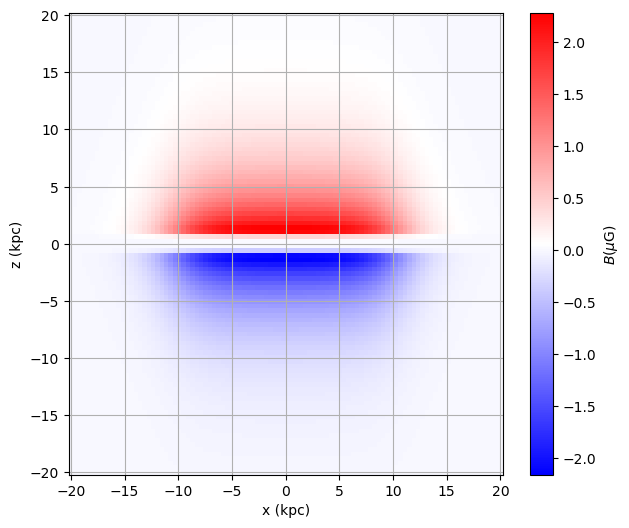

In [134]:
y = 0

# grid of x and z values
x = np.linspace(-20, 20, 100)
z = np.linspace(-20, 20, 100)
xx, zz = np.meshgrid(x, z, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(z)):
        B = get_toroidal_halo_field(xx[i,j], y, zz[i,j])
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], y)



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, zz, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

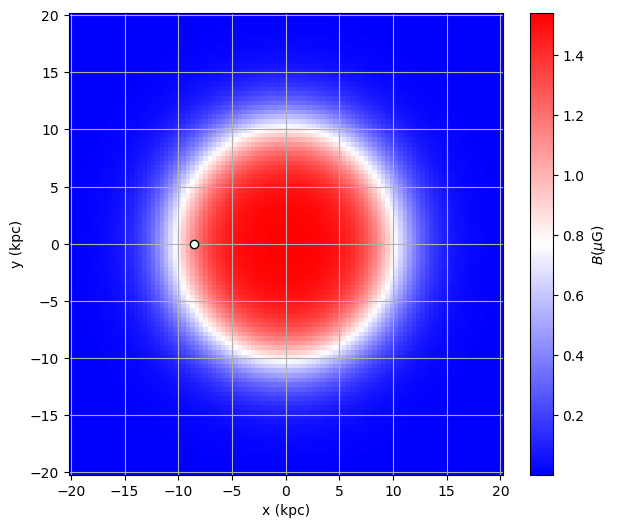

In [109]:
z = 3

# grid of x and y values
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_toroidal_halo_field(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

## Poloidal Halo Field

Also using parameters for base model

In [69]:
fModelType = "base"
def get_poloidal_halo_field(x, y, z):
    r2 = np.power(x, 2) + np.power(y, 2)
    r = np.sqrt(r2)
    
    c = np.power((fPoloidalA / fPoloidalZ), fPoloidalP)
    a0p = np.power(fPoloidalA, fPoloidalP)
    rp = np.power(r, fPoloidalP)
    abszp = np.power(np.abs(z), fPoloidalP)
    cabszp = c * abszp

    t0 = a0p + cabszp - rp
    t1 = np.sqrt(t0**2 + 4 * a0p * rp)
    ap = 2 * a0p * rp / (t1 + t0)

    if ap < 0:
        if r > np.finfo(float).eps:
            # This should never happen
            raise ValueError("ap = {}".format(ap))
        else:
            a = 0
    else:
        a = ap**(1 / fPoloidalP)
    
    # Eq. 29 and Eq. 32
    if fModelType == 'expX':
        radial_dependence = np.exp(-a / fPoloidalR)
    else:
        radial_dependence = 1 - sigmoid(a, fPoloidalR, fPoloidalW)

    # Eq. 28
    bzz = fPoloidalB * radial_dependence
    
    # r/a
    r_over_a = 1 / np.power((2 * a0p / (t1 + t0)), (1 / fPoloidalP))
    
    # Eq. 35 for p=n
    sign_z = -1 if z < 0 else 1
    br = bzz * c * a / r_over_a * sign_z * np.abs(z)**(fPoloidalP - 1) / t1
    
    # Eq. 36 for p=n
    bz = bzz * r_over_a**(fPoloidalP - 2) * (ap + a0p) / t1

    if r < np.finfo(float).eps:
        return Vector3(0, 0, bz)
    else:
        b_cyl_x = [br, 0, bz]
        cos_phi = x / r
        sin_phi = y / r
        return cyl_to_cart(b_cyl_x, cos_phi, sin_phi)

### Plotting

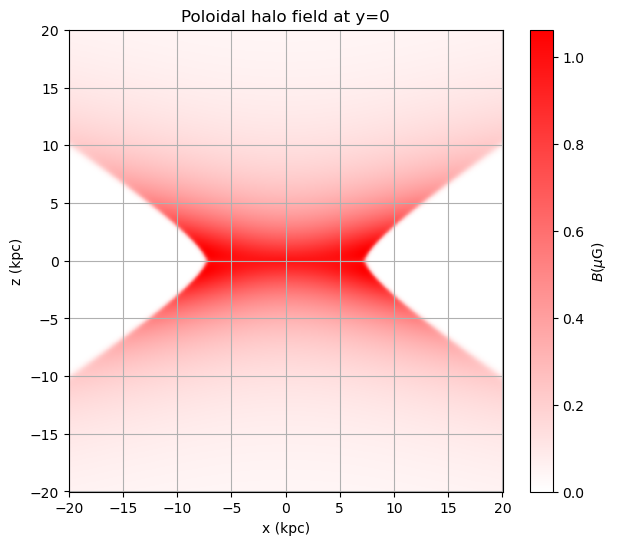

In [92]:
y = 0

# grid of x and z values
x = np.linspace(-20, 20, 1000)
z = np.linspace(-20, 20, 1000)
xx, zz = np.meshgrid(x, z, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(z)):
        B = get_poloidal_halo_field(xx[i,j], y, zz[i,j])
        B_strength[i,j] = np.linalg.norm(B) *sign_poloidal(B, zz[i,j])


cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])

plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, zz, B_strength, cmap=cmap0, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

plt.title(f'Poloidal halo field at y={y}')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

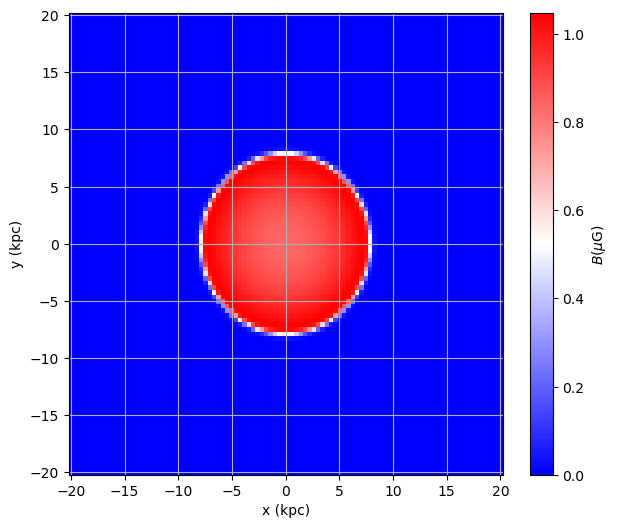

In [99]:
z = 1

# grid of x and y values
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_poloidal_halo_field(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
# plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

## Twisted Halo Field

 Parameters for twistX model

In [12]:
fDiskB1        =  1.3741995e+00 * microgauss
fDiskB2        =  2.0089881e+00 * microgauss
fDiskB3        =  1.5212463e+00 * microgauss
fDiskH         =  9.3806180e-01 * kpc
fDiskPhase1    =  2.3560316e+02 * degree
fDiskPhase2    =  1.0189856e+02 * degree
fDiskPhase3    =  5.6187572e+01 * degree
fDiskPitch     =  1.2100979e+01 * degree
fDiskW         =  1.4933338e-01 * kpc
fPoloidalB     =  6.2793114e-01 * microgauss
fPoloidalP     =  2.3292519e+00 * kpc
fPoloidalR     =  7.9212358e+00 * kpc
fPoloidalW     =  2.9056201e-01 * kpc
fPoloidalZ     =  2.6274437e+00 * kpc
fStriation     =  7.7616317e-01
fTwistingTime  =  5.4733549e+01 * megayear

In [13]:
def get_twisted_halo_field(x, y, z):
    r = np.sqrt(np.power(x, 2) + np.power(y, 2))
    cos_phi = x / r if r > np.finfo(float).eps else 1
    sin_phi = y / r if r > np.finfo(float).eps else 0

    b_x_cart = get_poloidal_halo_field(x, y, z)
    b_x_cyl = cart_to_cyl(b_x_cart, cos_phi, sin_phi)

    b_z = b_x_cyl[2]
    b_r = b_x_cyl[0]
    b_phi = 0

    if fTwistingTime != 0 and r != 0:
        # radial rotation curve parameters (fit to Reid et al 2014)
        v0 = -240 * kilometer / second
        r0 = 1.6 * kpc
        # vertical gradient (Levine+08)
        z0 = 10 * kpc

        # Eq. 43
        fr = 1 - np.exp(-r / r0)
        # Eq. 44
        t0 = np.exp(2 * np.abs(z) / z0)
        gz = 2 / (1 + t0)

        # Eq. 46
        sign_z = -1 if z < 0 else 1
        delta_z = -sign_z * v0 * fr / z0 * t0 * np.power(gz, 2)
        # Eq. 47
        delta_r = v0 * ((1 - fr) / r0 - fr / r) * gz

        # Eq. 45
        b_phi = (b_z * delta_z + b_r * delta_r) * fTwistingTime

    b_cyl_x = np.array([b_r, b_phi, b_z])
    return cyl_to_cart(b_cyl_x, cos_phi, sin_phi)

### Plotting

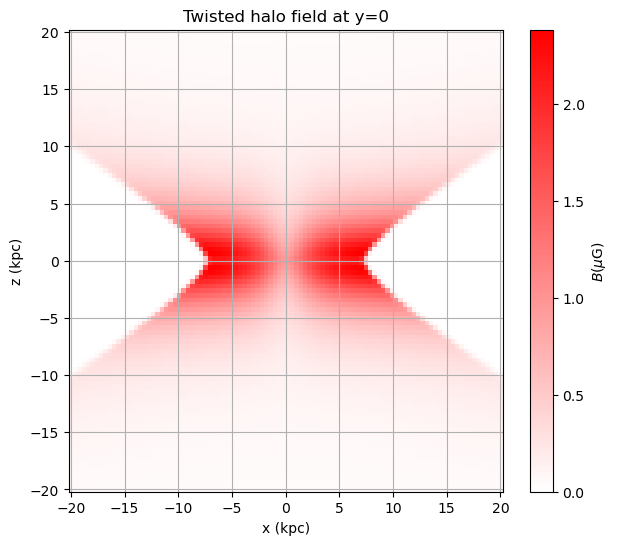

In [91]:
y = 0

# grid of x and z values
x = np.linspace(-20, 20, 100)
z = np.linspace(-20, 20, 100)
xx, zz = np.meshgrid(x, z, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(z)):
        B = get_twisted_halo_field(xx[i,j], y, zz[i,j])
        B_strength[i,j] = np.linalg.norm(B) *sign_poloidal(B, zz[i,j])


cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])

plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, zz, B_strength, cmap=cmap0, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

plt.title(f'Twisted halo field at y={y}')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

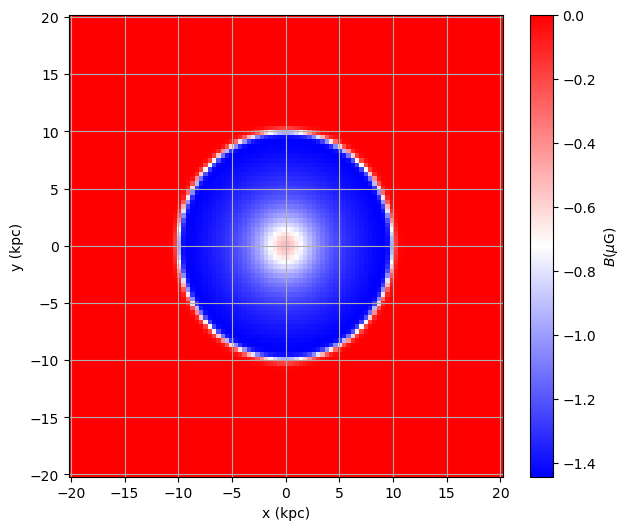

In [95]:
z = -3

# grid of x and y values
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
xx, yy = np.meshgrid(x, y, indexing='ij')

B_strength = np.zeros_like(xx)

for i in range(len(x)):
    for j in range(len(y)):
        B = get_twisted_halo_field(xx[i,j], yy[i,j], z)
        B_strength[i,j] = np.linalg.norm(B)*sign(B, xx[i,j], yy[i,j])



plt.figure(figsize=(7,6))
p = plt.pcolormesh(xx, yy, B_strength, cmap=plt.cm.bwr, shading='auto')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
# plt.plot(-8.5, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()